In [39]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 

In [1]:
from pandas_datareader import data as pdr
import yfinance  as yf


In [3]:
# aapl=pdr.get_data_yahoo('AAPL',start=datetime.datetime(2019,1,1),end=datetime.datetime(2023,1,1))

ticker = "HINDALCO.NS"  # Use "HINDALCO.BO" for BSE

# Define the start and end dates
start_date = "2016-01-01"
end_date = "2020-01-01"

# Download the historical data using yfinance
hindalco_data = yf.download(ticker, start=start_date, end=end_date)
hindalco_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,84.699997,85.250000,84.000000,84.900002,81.238235,2806421
2016-01-04,84.199997,85.900002,80.400002,80.750000,77.267227,8706224
2016-01-05,82.000000,83.949997,80.599998,82.599998,79.037430,9819068
2016-01-06,82.400002,82.849998,79.699997,80.550003,77.075859,6494446
2016-01-07,79.000000,79.400002,76.099998,76.650002,73.344063,8098318


In [4]:
hindalco_data.index

#inspect columns
hindalco_data.columns

# Select only last 10 observations of `Close`
ts=hindalco_data['Close'][-10:]

#type
type(ts)

pandas.core.series.Series

In [15]:
print(hindalco_data.loc[pd.Timestamp('2016, 1, 1'):pd.Timestamp('2020, 1, 1')].head())
print(hindalco_data.loc['2017'].head())
print(hindalco_data.iloc[22:43])
print(hindalco_data.iloc[[1,2],[3,5]])

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2016-01-01  84.699997  85.250000  84.000000  84.900002  81.238235  2806421
2016-01-04  84.199997  85.900002  80.400002  80.750000  77.267227  8706224
2016-01-05  82.000000  83.949997  80.599998  82.599998  79.037430  9819068
2016-01-06  82.400002  82.849998  79.699997  80.550003  77.075859  6494446
2016-01-07  79.000000  79.400002  76.099998  76.650002  73.344063  8098318
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-02  155.850006  159.750000  154.199997  158.850006  152.971558   
2017-01-03  159.850006  161.000000  157.050003  158.850006  152.971558   
2017-01-04  158.899994  161.600006  157.449997  158.899994  153.019699   
2017-01-05  160.000000  162.649994  159.899994  162.000000  156.004974   
2017-01-06  162.449997  163.800

In [28]:
#sample 20 rows
sample=hindalco_data.sample(20)

#resample  to monthly level
monthly_hindalco=hindalco_data.resample('M')
#
print(monthly_hindalco)

DatetimeIndexResampler [freq=<MonthEnd>, axis=0, closed=right, label=right, convention=start, origin=start_day]


In [30]:
#Add diff to hindalco_data
hindalco_data['diff']=hindalco_data.Open-hindalco_data.Close
del hindalco_data['diff']

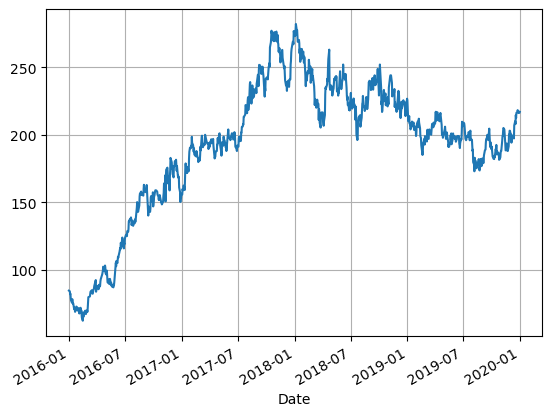

In [34]:
import matplotlib.pyplot as plt
hindalco_data['Open'].plot(grid=True)
plt.show()

In [35]:
# Isolate the adjusted Closing prices
adj_closing_px=hindalco_data['Adj Close']

#Calculate the moving average
moving_avg=adj_closing_px.rolling(window=40).mean()
#inspect the result
moving_avg[-10:]


Date
2019-12-17    191.548639
2019-12-18    192.231553
2019-12-19    192.995241
2019-12-20    193.831137
2019-12-23    194.648674
2019-12-24    195.484570
2019-12-26    196.236020
2019-12-27    196.927501
2019-12-30    197.663040
2019-12-31    198.211328
Name: Adj Close, dtype: float64

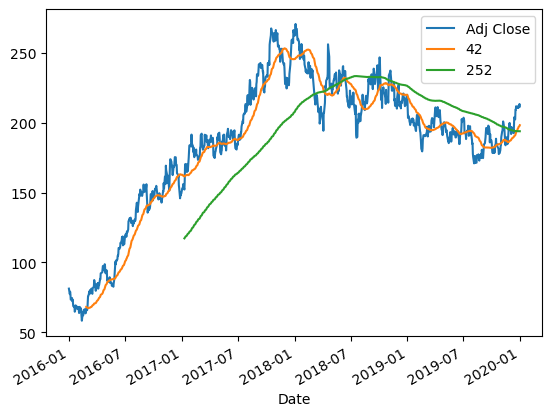

In [36]:
#short moving window rolling mean
hindalco_data['42']=adj_closing_px.rolling(window=40).mean()
hindalco_data['252']=adj_closing_px.rolling(window=252).mean(
)

#Plot adj closing price ,the short and long windows of rolling means
hindalco_data[['Adj Close','42','252']].plot()
plt.show()

In [51]:
#initialize shot and long windows
short_window=40
long_window=100

#Initialize the `signals`` DataFrame with the `signal` column

signals=pd.DataFrame(index=hindalco_data.index) 
signals['signal']=0.0

#Create the short simple moving avg over the short window
signals['short_mavg']=hindalco_data['Close'].rolling(window=short_window).mean()

#Create the long  simple moving avg over the short window
signals['long_mavg']=hindalco_data['Close'].rolling(window=long_window).mean()

#create signals
signals['signal'][short_window:]=np.where(signals['short_mavg'][short_window:]
                                          >signals['long_mavg'][short_window:],1.0 , 0.0)
signals.tail(10)
 
 #generate trading orders

signals['positions']=signals['signal'].diff()

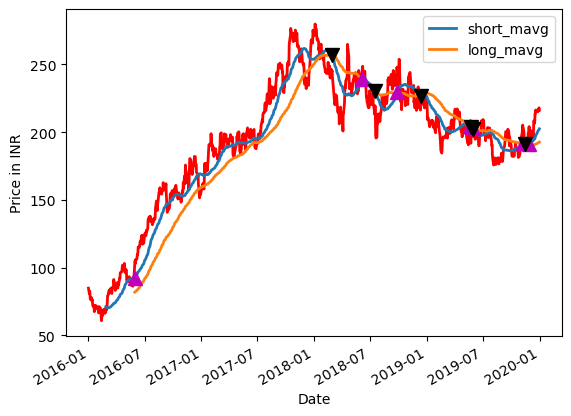

In [58]:
#initialize the plot figure
fig= plt.figure()
# Add a subplot and label for y axis

ax1=fig.add_subplot(111,ylabel="Price in INR")

#plot the closing prices
hindalco_data['Close'].plot(ax=ax1,color='r',lw=2.)

#plot the short and long moving averages 
signals[['short_mavg','long_mavg']].plot(ax=ax1,lw=2.)

#plot the buy signal

ax1.plot(signals.loc[signals.positions==1.0].index,
         signals.short_mavg[signals.positions==1.0],'^',markersize=10,color='m')

#plot the sell signals
ax1.plot(signals.loc[signals.positions==-1.0].index,
signals.short_mavg[signals.positions==-1.0],
'v',
markersize=10,color='k'
)


In [59]:
#set the  initial capital
initial_capital=100000

#create a DataFrame `positions`
positions=pd.DataFrame(index=signals.index).fillna(0.0)

#Buy 100 shares
positions['HINDALCO.NS']=100*signals['signal']

#initialize portfolio with value owned
portfolio=positions.multiply(hindalco_data['Adj Close'],axis=0)

#store the difference in the share owned

pos_diff=positions.diff()


# Add `holdings` to portfolio
portfolio['holdings']=(positions.multiply(hindalco_data['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(hindalco_data['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()



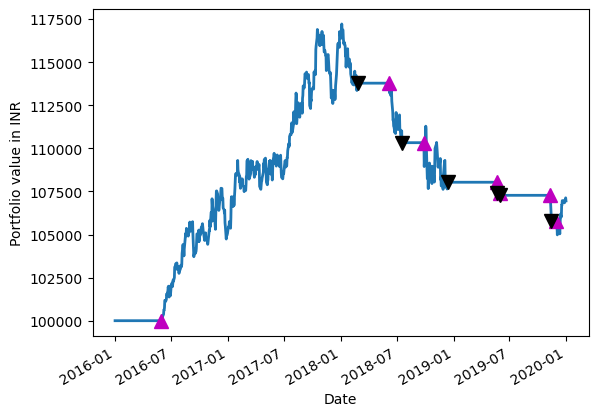

In [64]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in INR')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()
